"I/we certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work."



> Implementing Double DQN on cartpole environment



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
# from gym import spaces
import tensorflow as tf
import random, math, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
cart_pole_env = gym.make('CartPole-v1')
print(cart_pole_env.observation_space)
print(cart_pole_env.action_space)

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Discrete(2)


Below is the replay buffer class

In [3]:
class Agent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, observation):
    return np.random.choice(self.action_space.n)

Below is the NN initialization, training class

> Indented block



In [4]:
def helper(numpy_array):
  arg = tf.convert_to_tensor(numpy_array, dtype=tf.float32)
  return arg

In [14]:
class Actor:
  def __init__(self, alfr, actor_input_state_dim, actor_output_action_dim):
    self.model = self.actor_network_model(alfr, actor_input_state_dim, actor_output_action_dim)
    self.opt = tf.keras.optimizers.Adam(0.0005)

  def actor_network_model(self, alr, actor_input_state_dim,actor_output_action_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(actor_output_action_dim, activation='softmax'))
    return model

  def actor_train(self, obs, action, adv):
    with tf.GradientTape() as tape:
      actor_pred = self.model(obs, training=True)
      actor_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(action, actor_pred,sample_weight=tf.stop_gradient(adv))
    grads = tape.gradient(actor_loss, self.model.trainable_variables)
    self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
    return actor_loss

In [15]:
class Critic:
  def __init__(self, clr, critic_input_state_dim, critic_output_action_dim):
    self.model = self.critic_network_model(clr, critic_input_state_dim, critic_output_action_dim)
    self.opt = tf.keras.optimizers.Adam(0.0005)

  def critic_network_model(self,clr,critic_input_state_dim,critic_output_action_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=critic_input_state_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(critic_output_action_dim, activation='linear'))
    return model
    
  def critic_train(self, obs, adv):
    with tf.GradientTape() as tape:
      critic_pred = self.model(obs, training=True)
      critic_loss = tf.keras.losses.MeanSquaredError()(tf.stop_gradient(adv), critic_pred)
    critic_grads = tape.gradient(critic_loss, self.model.trainable_variables)
    self.opt.apply_gradients(zip(critic_grads, self.model.trainable_variables))
    return critic_loss

In [16]:
class A2C:
  def __init__(self,env,agent):
    self.env = env
    self.agent = agent
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.reward_per_episode = []
    self.average_reward = [0]*10
    self.self_action = 1

  def train(self,episodes,gamma,actor_lr, critic_lr):
    obs = self.env.reset()
    obs_size = 4
    action_size = self.env.action_space.n
    self.actor = Actor(actor_lr,obs_size,action_size)
    self.critic = Critic(critic_lr,obs_size,1)
    average_idx = 0

    #print("8: episodes begin")
    for eps_n in range(episodes):
        obs = self.env.reset()
        done_iter = False
        cumm_reward=0
        step_no=1

        #print("9: steps start for episode {}".format(str(eps_n)))
        while not done_iter:
          
          obs_reshaped = tf.reshape(helper(obs),(1,obs_size))

          next_q = self.actor.model.predict(obs_reshaped)
          #print("next_q: {}".format(next_q))

          action_prob = tfp.distributions.Categorical(probs=next_q)
          #print("action_prob {}".format(action_prob))
          action = action_prob.sample()

          action_scaler = tf.gather(action,0).numpy()
          #print("action_scaler: {}".format(action_scaler))

          obs_next, reward, done_iter, info = self.env.step(action_scaler)
          #print("obs_next: {}".format(obs_next))
          #print("reward: {}".format(reward))
          #print("done_iter: {}".format(done_iter))
          #print("info: {}".format(info))

          critic_obs = self.critic.model.predict(obs_reshaped) 
          #print("critic_obs: {}".format(critic_obs))

          obs_next_reshaped = tf.reshape(helper(obs_next),(1,obs_size))
          critic_obs_next = self.critic.model.predict(obs_next_reshaped) 
          #print("critic_obs_next: {}".format(critic_obs_next))

          adv = reward + (1-done_iter)*gamma*critic_obs_next - critic_obs
          #print("self.adv: {}".format(self.adv))

          critic_loss = self.critic.critic_train(obs_reshaped, adv+critic_obs)
          actor_loss = self.actor.actor_train(obs_reshaped,action, adv)

          cumm_reward += reward
          obs = obs_next
          step_no += 1

        self.reward_per_episode.append(cumm_reward)
        average_idx = 0 if average_idx == 9 else 1 + average_idx
        self.average_reward[average_idx] = cumm_reward
        avg_reward = int(sum(self.average_reward)/len(self.average_reward))
        if avg_reward >470: 
          break 
          print("average reward for the last consecutive episodes is "+ avg_reward +"greater than 470")
        print("cummulative reward is " + str(cumm_reward) + " for episode no. " + str(eps_n + 1)  )  

          
          

In [17]:

agent = Agent(cart_pole_env)

number_of_episodes = 1000

a2c = A2C(cart_pole_env,agent)

a2c.train(episodes = number_of_episodes,gamma = 0.99, actor_lr = 0.001, critic_lr = 0.001)

8: episodes begin
9: steps start for episode 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


cummulative reward is 33.0 for episode no. 1
9: steps start for episode 1
cummulative reward is 20.0 for episode no. 2
9: steps start for episode 2
cummulative reward is 21.0 for episode no. 3
9: steps start for episode 3
cummulative reward is 37.0 for episode no. 4
9: steps start for episode 4
cummulative reward is 24.0 for episode no. 5
9: steps start for episode 5
cummulative reward is 25.0 for episode no. 6
9: steps start for episode 6
cummulative reward is 17.0 for episode no. 7
9: steps start for episode 7
cummulative reward is 10.0 for episode no. 8
9: steps start for episode 8
cummulative reward is 17.0 for episode no. 9
9: steps start for episode 9
cummulative reward is 13.0 for episode no. 10
9: steps start for episode 10
cummulative reward is 15.0 for episode no. 11
9: steps start for episode 11
cummulative reward is 16.0 for episode no. 12
9: steps start for episode 12
cummulative reward is 10.0 for episode no. 13
9: steps start for episode 13
cummulative reward is 8.0 for 

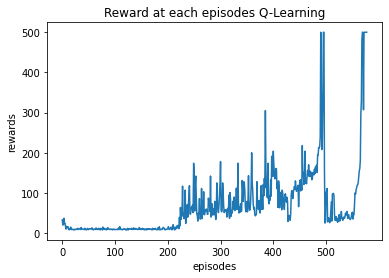

In [18]:
#Reward at each iteration DQ-Learning
plt.plot(a2c.reward_per_episode) 
plt.xticks(range(0,len(a2c.reward_per_episode)+1, 100)) 

plt.ylabel('rewards')
plt.xlabel('episodes') 
plt.title("Reward at each episodes Q-Learning") 
plt.show()

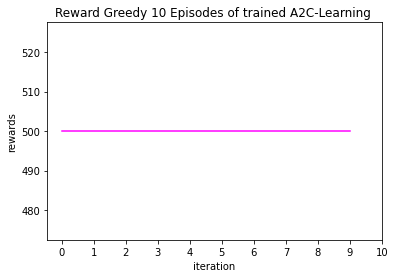

In [19]:
#evaluate Q learning
gamma = 0.99

reward_A2Clearning_10ep = []
for i in np.arange(10):
    obs = a2c.env.reset()
    done_iter = False
    print(i,end="\r")
    cumm_reward=0
    step_no = 0

    while not done_iter:
      obs_reshaped = tf.reshape(helper(obs),(1,4))
      next_q = a2c.actor.model.predict(obs_reshaped)
      action_dist = tfp.distributions.Categorical(probs=next_q)
      action = action_dist.sample()
      action_scaler = tf.gather(action,0).numpy()
      obs_next, reward, done_iter, info = a2c.env.step(action_scaler)
      #action = int(a2c.greedy_act_max(obs.reshape(1,4)))
      cumm_reward += reward
      obs = obs_next
      # done_iter = done
      step_no += 1
    reward_A2Clearning_10ep.append(cumm_reward)

plt.plot(reward_A2Clearning_10ep,color='magenta') 
plt.xticks(range(0,len(reward_A2Clearning_10ep)+1, 1)) 

plt.ylabel('rewards')
plt.xlabel('iteration') 
plt.title("Reward Greedy 10 Episodes of trained A2C-Learning ") 
plt.show()